## INITIAL PREPARATION

In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from unidecode import unidecode
from rich import print
from rich.console import Console
from rich.table import Column, Table
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type

In [164]:
console = Console()

In [165]:
data = pd.read_csv("./initial_nobel_data.csv")
data

,year,category,prize,motivation,prize_share,laureate_id,laureate_type,full_name,birth_date,birth_city,birth_country,sex,organization_name,organization_city,organization_country,death_date,death_city,death_country
0,1901,Chemistry,The Nobel Prize in Chemistry 1901,"""in recognition of the extraordinary services ...",1/1,160,Individual,Jacobus Henricus van 't Hoff,1852-08-30,Rotterdam,Netherlands,Male,Berlin University,Berlin,Germany,1911-03-01,Berlin,Germany
1,1901,Literature,The Nobel Prize in Literature 1901,"""in special recognition of his poetic composit...",1/1,569,Individual,Sully Prudhomme,1839-03-16,Paris,France,Male,NaN,NaN,NaN,1907-09-07,Châtenay,France
2,1901,Medicine,The Nobel Prize in Physiology or Medicine 1901,"""for his work on serum therapy, especially its...",1/1,293,Individual,Emil Adolf von Behring,1854-03-15,Hansdorf (Lawice),Prussia (Poland),Male,Marburg University,Marburg,Germany,1917-03-31,Marburg,Germany
3,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,462,Individual,Jean Henry Dunant,1828-05-08,Geneva,Switzerland,Male,NaN,NaN,NaN,1910-10-30,Heiden,Switzerland
4,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,463,Individual,Frédéric Passy,1822-05-20,Paris,France,Male,NaN,NaN,NaN,1912-06-12,Paris,France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,2016,Medicine,The Nobel Prize in Physiology or Medicine 2016,"""for his discoveries of mechanisms for autophagy""",1/1,927,Individual,Yoshinori Ohsumi,1945-02-09,Fukuoka,Japan,Male,Tokyo Institute of Technology,Tokyo,Japan,NaN,NaN,NaN
907,2016,Peace,The Nobel Peace Prize 2016,"""for his resolute efforts to bring the country...",1/1,934,Individual,Juan Manuel Santos,1951-08-10,Bogotá,Colombia,Male,NaN,NaN,NaN,NaN,NaN,NaN
908,2016,Physics,The Nobel Prize in Physics 2016,"""for theoretical discoveries of topological ph...",1/2,928,Individual,David J. Thouless,1934-09-21,Bearsden,United Kingdom,Male,University of Washington,"Seattle, WA",United States of America,NaN,NaN,NaN
909,2016,Physics,The Nobel Prize in Physics 2016,"""for theoretical discoveries of topological ph...",1/4,929,Individual,F. Duncan M. Haldane,1951-09-14,London,United Kingdom,Male,Princeton University,"Princeton, NJ",United States of America,NaN,NaN,NaN


## DATA CLEANING

In [166]:
def correct_faulty_characters(text):
    """Corrects faulty characters in a given text string using the unidecode library."""
    if pd.isnull(text):
        return text
    return unidecode(str(text))

In [167]:
def clean_dataframe(df, columns):
    """Corrects faulty characters in specified columns of a Pandas DataFrame."""
    change_counts = {}
    df_cleaned = df.copy()

    for col in columns:
        if col in df_cleaned.columns:
            original_column = df_cleaned[col].astype(str).copy()
            df_cleaned[col] = original_column.apply(correct_faulty_characters)
            change_counts[col] = (original_column != df_cleaned[col]).sum()
        else:
            print(f"Warning: Column '{col}' not found in DataFrame. Skipping.")
            change_counts[col] = None

    table = Table(title="Character Correction Summary")
    table.add_column("Column")
    table.add_column("Changes")

    for col, count in change_counts.items():
        table.add_row(col, str(count) if count is not None else "Not Processed")

    console.print(table)
    return df_cleaned

In [168]:
def convert_to_datetime(df, columns, input_format='%Y-%m-%d'):
    """Converts specified columns in a DataFrame to datetime objects."""
    for col in columns:
        if col in df.columns:
            try:
                df[col] = pd.to_datetime(df[col], format=input_format, errors='coerce')
            except ValueError as e:
                print(f"ValueError in column '{col}': {e}. Check your input_format.")
            except Exception as e:
                print(f"An unexpected error occurred in column '{col}': {e}")
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    return df


In [169]:
def calculate_age_at_award(data):
    """Calculates the age at the time of the Nobel Prize award."""
    data['birth_date'] = pd.to_datetime(data['birth_date'], errors='coerce')
    data['death_date'] = pd.to_datetime(data['death_date'], errors='coerce')
    data['year'] = pd.to_numeric(data['year'], errors='coerce').dropna().astype(int)

    data['birth_year'] = data['birth_date'].dt.year
    data['age_at_award'] = data['year'] - data['birth_year']
    data['age_at_award'] = data['age_at_award'].round(0).astype('Int64')

    return data

In [170]:
def convert_prize_share_vectorized(series):
    """Converts prize share strings to floats using vectorized operations."""
    series = series.astype(str)
    mask = series.str.contains('/')
    new_series = series.copy()
    for index in series[mask].index:
        try:
            numerator, denominator = map(int, series[index].split('/'))
            new_series[index] = numerator / denominator
        except:
            new_series[index] = np.nan
    new_series = pd.to_numeric(new_series, errors='coerce')
    return new_series

In [171]:
def correct_laureate_type(data):
    """Corrects laureate types to be 'Individual' for organizations with assigned sexes."""
    mask = (data['laureate_type'] == 'Organization') & (~data['sex'].isna())
    data['laureate_type'] = np.where(mask, 'Individual', data['laureate_type'])
    return data

In [172]:
def fill_missing_countries(data):
    """Fills missing birth and organization countries with 'International'."""
    data['organization_country'].fillna('International', inplace=True)
    data['birth_country'].fillna('International', inplace=True)
    return data

In [173]:
# LidingÃ¶-Stockholm ?? nope.
data.iloc[73]

year                                                                 1912
category                                                          Physics
prize                                     The Nobel Prize in Physics 1912
motivation              "for his invention of automatic regulators for...
prize_share                                                           1/1
laureate_id                                                            17
laureate_type                                                  Individual
full_name                                               Nils Gustaf Dalén
birth_date                                                     1869-11-30
birth_city                                                      Stenstorp
birth_country                                                      Sweden
sex                                                                  Male
organization_name                             Swedish Gas-Accumulator Co.
organization_city                     

In [174]:
data.isnull().sum()

year                      0
category                  0
prize                     0
motivation               88
prize_share               0
laureate_id               0
laureate_type             0
full_name                 0
birth_date               28
birth_city               28
birth_country            26
sex                      26
organization_name       246
organization_city       244
organization_country    244
death_date              318
death_city              335
death_country           329
dtype: int64

In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911 entries, 0 to 910
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   year                  911 non-null    int64 
 1   category              911 non-null    object
 2   prize                 911 non-null    object
 3   motivation            823 non-null    object
 4   prize_share           911 non-null    object
 5   laureate_id           911 non-null    int64 
 6   laureate_type         911 non-null    object
 7   full_name             911 non-null    object
 8   birth_date            883 non-null    object
 9   birth_city            883 non-null    object
 10  birth_country         885 non-null    object
 11  sex                   885 non-null    object
 12  organization_name     665 non-null    object
 13  organization_city     667 non-null    object
 14  organization_country  667 non-null    object
 15  death_date            593 non-null    ob

In [176]:
date_columns = ['birth_date', 'death_date']
data = convert_to_datetime(data, date_columns)

In [177]:
data["year"] = pd.to_numeric(data["year"], errors="coerce").dropna().astype(int)

In [178]:
data['prize_share'] = convert_prize_share_vectorized(data['prize_share'])
data = correct_laureate_type(data)
data = fill_missing_countries(data)

In [179]:
nsc = data[data["sex"].isnull()][["laureate_type", "sex", "birth_country", "organization_country"]]
print(nsc)


laureate_type  sex  birth_country organization_country
24   Organization  NaN  International        International
60   Organization  NaN  International        International
89   Organization  NaN  International        International
200  Organization  NaN  International        International
215  Organization  NaN  International        International
237  Organization  NaN  International        International
238  Organization  NaN  International        International
283  Organization  NaN  International        International
348  Organization  NaN  International        International
349  Organization  NaN  International        International
366  Organization  NaN  International        International
399  Organization  NaN  International        International
479  Organization  NaN  International        International
523  Organization  NaN  International        International
558  Organization  NaN  International        International
588  Organization  NaN  International        International
659  Organization  NaN  International        International
682  Organization  NaN  International        International
703  Organization  NaN  International        International
729  Organization  NaN  International        International
778  Organization  NaN  International        International
789  Organization  NaN  International        International
800  Organization  NaN  International        International
860  Organization  NaN  International        International
873  Organization  NaN  International        International
897  Organization  NaN  International        International

In [180]:
data = calculate_age_at_award(data)

In [183]:
data['organization_country'].fillna('International', inplace=True)

data['birth_country'].fillna('International', inplace=True)
data

,year,category,prize,motivation,prize_share,laureate_id,laureate_type,full_name,birth_date,birth_city,birth_country,sex,organization_name,organization_city,organization_country,death_date,death_city,death_country,birth_year,age_at_award
0,1901,Chemistry,The Nobel Prize in Chemistry 1901,"""in recognition of the extraordinary services ...",1.00,160,Individual,Jacobus Henricus van 't Hoff,1852-08-30,Rotterdam,Netherlands,Male,Berlin University,Berlin,Germany,1911-03-01,Berlin,Germany,1852.0,49
1,1901,Literature,The Nobel Prize in Literature 1901,"""in special recognition of his poetic composit...",1.00,569,Individual,Sully Prudhomme,1839-03-16,Paris,France,Male,NaN,NaN,International,1907-09-07,Châtenay,France,1839.0,62
2,1901,Medicine,The Nobel Prize in Physiology or Medicine 1901,"""for his work on serum therapy, especially its...",1.00,293,Individual,Emil Adolf von Behring,1854-03-15,Hansdorf (Lawice),Prussia (Poland),Male,Marburg University,Marburg,Germany,1917-03-31,Marburg,Germany,1854.0,47
3,1901,Peace,The Nobel Peace Prize 1901,NaN,0.50,462,Individual,Jean Henry Dunant,1828-05-08,Geneva,Switzerland,Male,NaN,NaN,International,1910-10-30,Heiden,Switzerland,1828.0,73
4,1901,Peace,The Nobel Peace Prize 1901,NaN,0.50,463,Individual,Frédéric Passy,1822-05-20,Paris,France,Male,NaN,NaN,International,1912-06-12,Paris,France,1822.0,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,2016,Medicine,The Nobel Prize in Physiology or Medicine 2016,"""for his discoveries of mechanisms for autophagy""",1.00,927,Individual,Yoshinori Ohsumi,1945-02-09,Fukuoka,Japan,Male,Tokyo Institute of Technology,Tokyo,Japan,NaT,NaN,NaN,1945.0,71
907,2016,Peace,The Nobel Peace Prize 2016,"""for his resolute efforts to bring the country...",1.00,934,Individual,Juan Manuel Santos,1951-08-10,Bogotá,Colombia,Male,NaN,NaN,International,NaT,NaN,NaN,1951.0,65
908,2016,Physics,The Nobel Prize in Physics 2016,"""for theoretical discoveries of topological ph...",0.50,928,Individual,David J. Thouless,1934-09-21,Bearsden,United Kingdom,Male,University of Washington,"Seattle, WA",United States of America,NaT,NaN,NaN,1934.0,82
909,2016,Physics,The Nobel Prize in Physics 2016,"""for theoretical discoveries of topological ph...",0.25,929,Individual,F. Duncan M. Haldane,1951-09-14,London,United Kingdom,Male,Princeton University,"Princeton, NJ",United States of America,NaT,NaN,NaN,1951.0,65


In [182]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 911 entries, 0 to 910
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   year                  911 non-null    int32         
 1   category              911 non-null    object        
 2   prize                 911 non-null    object        
 3   motivation            823 non-null    object        
 4   prize_share           911 non-null    float64       
 5   laureate_id           911 non-null    int64         
 6   laureate_type         911 non-null    object        
 7   full_name             911 non-null    object        
 8   birth_date            883 non-null    datetime64[ns]
 9   birth_city            883 non-null    object        
 10  birth_country         911 non-null    object        
 11  sex                   885 non-null    object        
 12  organization_name     665 non-null    object        
 13  organization_city   

In [ ]:
# to store cleaned data, optional
# data.to_csv('final_nobel.csv', index=False)

## QUESTIONS

### QUESTION 1 - Nobel Ödüllerini en çok kazanan ilk on ülkeyi bulunuz.

In [185]:
def plot_top_countries(data, n=10):
    """
    Plots the top N countries with the most Nobel Prizes using an interactive bar chart.
    Also prints a rich table with counts.
    """
    top_countries = data['birth_country'].value_counts().nlargest(n)
    fig = px.bar(x=top_countries.index, y=top_countries.values,
                 labels={'x': 'Country', 'y': 'Number of Nobel Prizes'},
                 title=f'Top {n} Countries with the Most Nobel Prizes')
    fig.update_layout(xaxis_tickangle=-45)

    table = Table(title=f"Top {n} Countries")
    table.add_column("Country")
    table.add_column("Number of Prizes")

    for country, count in top_countries.items():
        table.add_row(country, str(count))

    console.print(table)
    fig.show()

plot_top_countries(data)

               Top 10 Countries                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Country                  ┃ Number of Prizes ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ United States of America │ 259              │
│ United Kingdom           │ 85               │
│ Germany                  │ 61               │
│ France                   │ 51               │
│ Sweden                   │ 29               │
│ International            │ 26               │
│ Japan                    │ 24               │
│ Canada                   │ 18               │
│ Netherlands              │ 18               │
│ Italy                    │ 17               │
└──────────────────────────┴──────────────────┘

### QUESTION 2 - Nobel Ödüllerini kazanan ilk kadınları listeleyiniz.

In [ ]:
def find_first_laureates(data, sex):
    """Finds the first Nobel laureate of a given sex."""
    subset = data[data['sex'] == sex].sort_values('year')
    if not subset.empty:
        first = subset.iloc[0]
        return first[['year', 'category', 'full_name', 'birth_country']]
    else:
        return None


First Female Laureate:
 year                                    1903
category                             Physics
full_name        Marie Curie, née Sklodowska
birth_country        Russian Empire (Poland)
Name: 19, dtype: object

In [197]:
first_female = find_first_laureates(data, 'Female')
console.print(f"First Female Laureate:\n {first_female}", style="yellow")

First Female Laureate:
 year                                    1903
category                             Physics
full_name        Marie Curie, née Sklodowska
birth_country        Russian Empire (Poland)
Name: 19, dtype: object

### QUESTION 3 - Nobel Ödüllerini kazanan ilk erkekleri listeleyiniz.

In [196]:
first_male = find_first_laureates(data, 'Male')
console.print(f"\nFirst Male Laureate:\n {first_male}", style="green")

First Male Laureate:
 year                                     1901
category                            Chemistry
full_name        Jacobus Henricus van 't Hoff
birth_country                     Netherlands
Name: 0, dtype: object

### QUESTION 4 - Nobel ödülünü en çok kazanan ülkenin hangi yıldan itibaren hakimiyet sağladığını görselleştirip bu hakimiyette rol oynayan şeyler nelerdir? İçgörülerinizi paylaşır mısınız?

In [198]:
def plot_country_dominance(data):
    """
    Analyzes and visualizes the dominance of the country with the most Nobel Prizes over time.
    Generates two separate plots: one for yearly counts and one for the moving average.
    """
    country_counts = data['birth_country'].value_counts()
    most_winning_country = country_counts.index[0]
    most_winning_country_data = data[data['birth_country'] == most_winning_country]
    yearly_counts = most_winning_country_data.groupby('year')['birth_country'].count().reset_index()
    yearly_counts.rename(columns={'birth_country': 'count'}, inplace=True)
    yearly_counts['moving_average'] = yearly_counts['count'].rolling(window=5, center=True).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(yearly_counts['year'], yearly_counts['count'], marker='o', color='navy')
    plt.title(f'Nobel Prizes Won by {most_winning_country} Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Prizes')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(yearly_counts['year'], yearly_counts['moving_average'], marker='o', color='orange')
    plt.title(f'5-Year Moving Average of Nobel Prizes Won by {most_winning_country}')
    plt.xlabel('Year')
    plt.ylabel('Moving Average')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nThe country with the most Nobel Prizes is: {most_winning_country}")

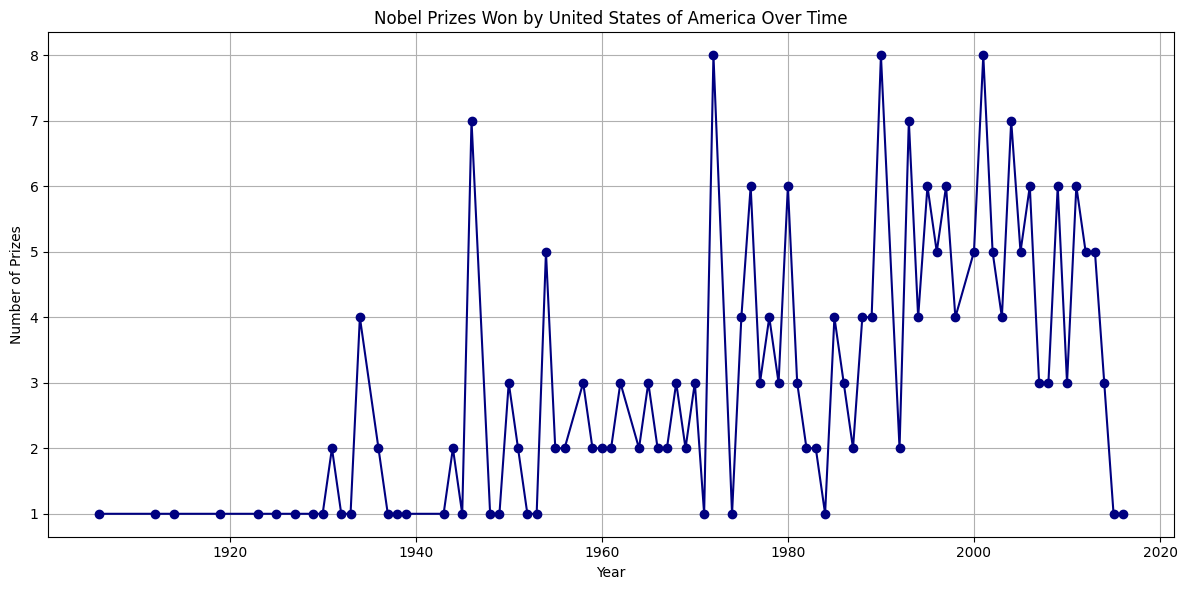

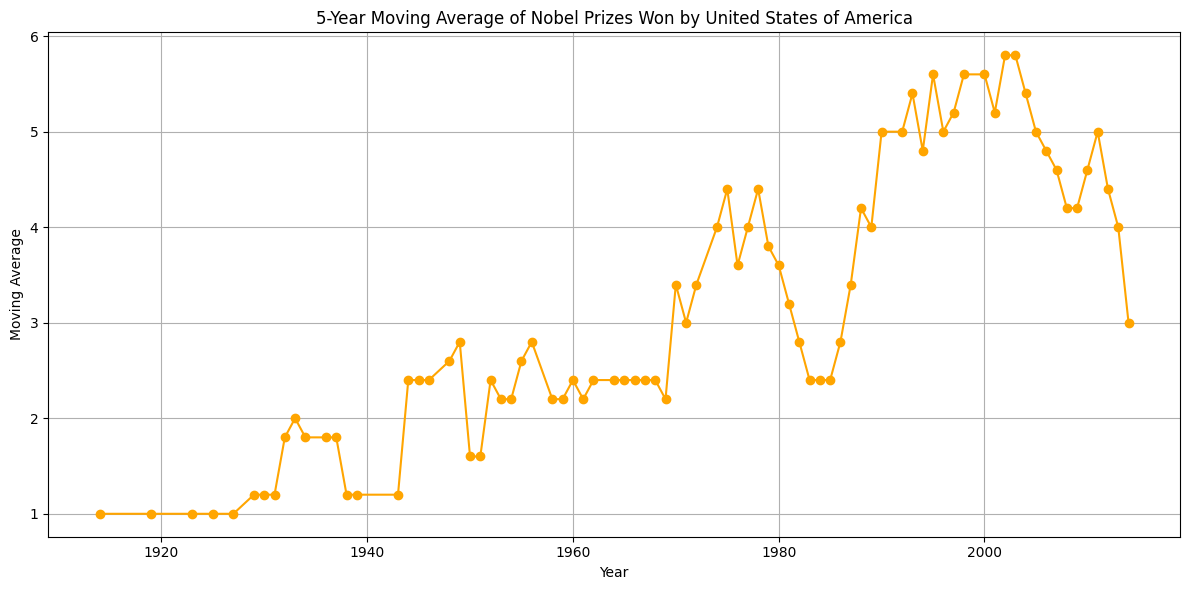

The country with the most Nobel Prizes is: United States of America

In [199]:
plot_country_dominance(data)

### QUESTION 5 - Nobel Ödülü kazananların cinsiyetlerini, yaşlarını, ödül kategorisi ve yılları kullanarak görselleştiriniz.(Her bir ödül kategorisi için ayrı grafik gösteriniz) Çıkan sonuçlara göre görseli yorumlayınız.

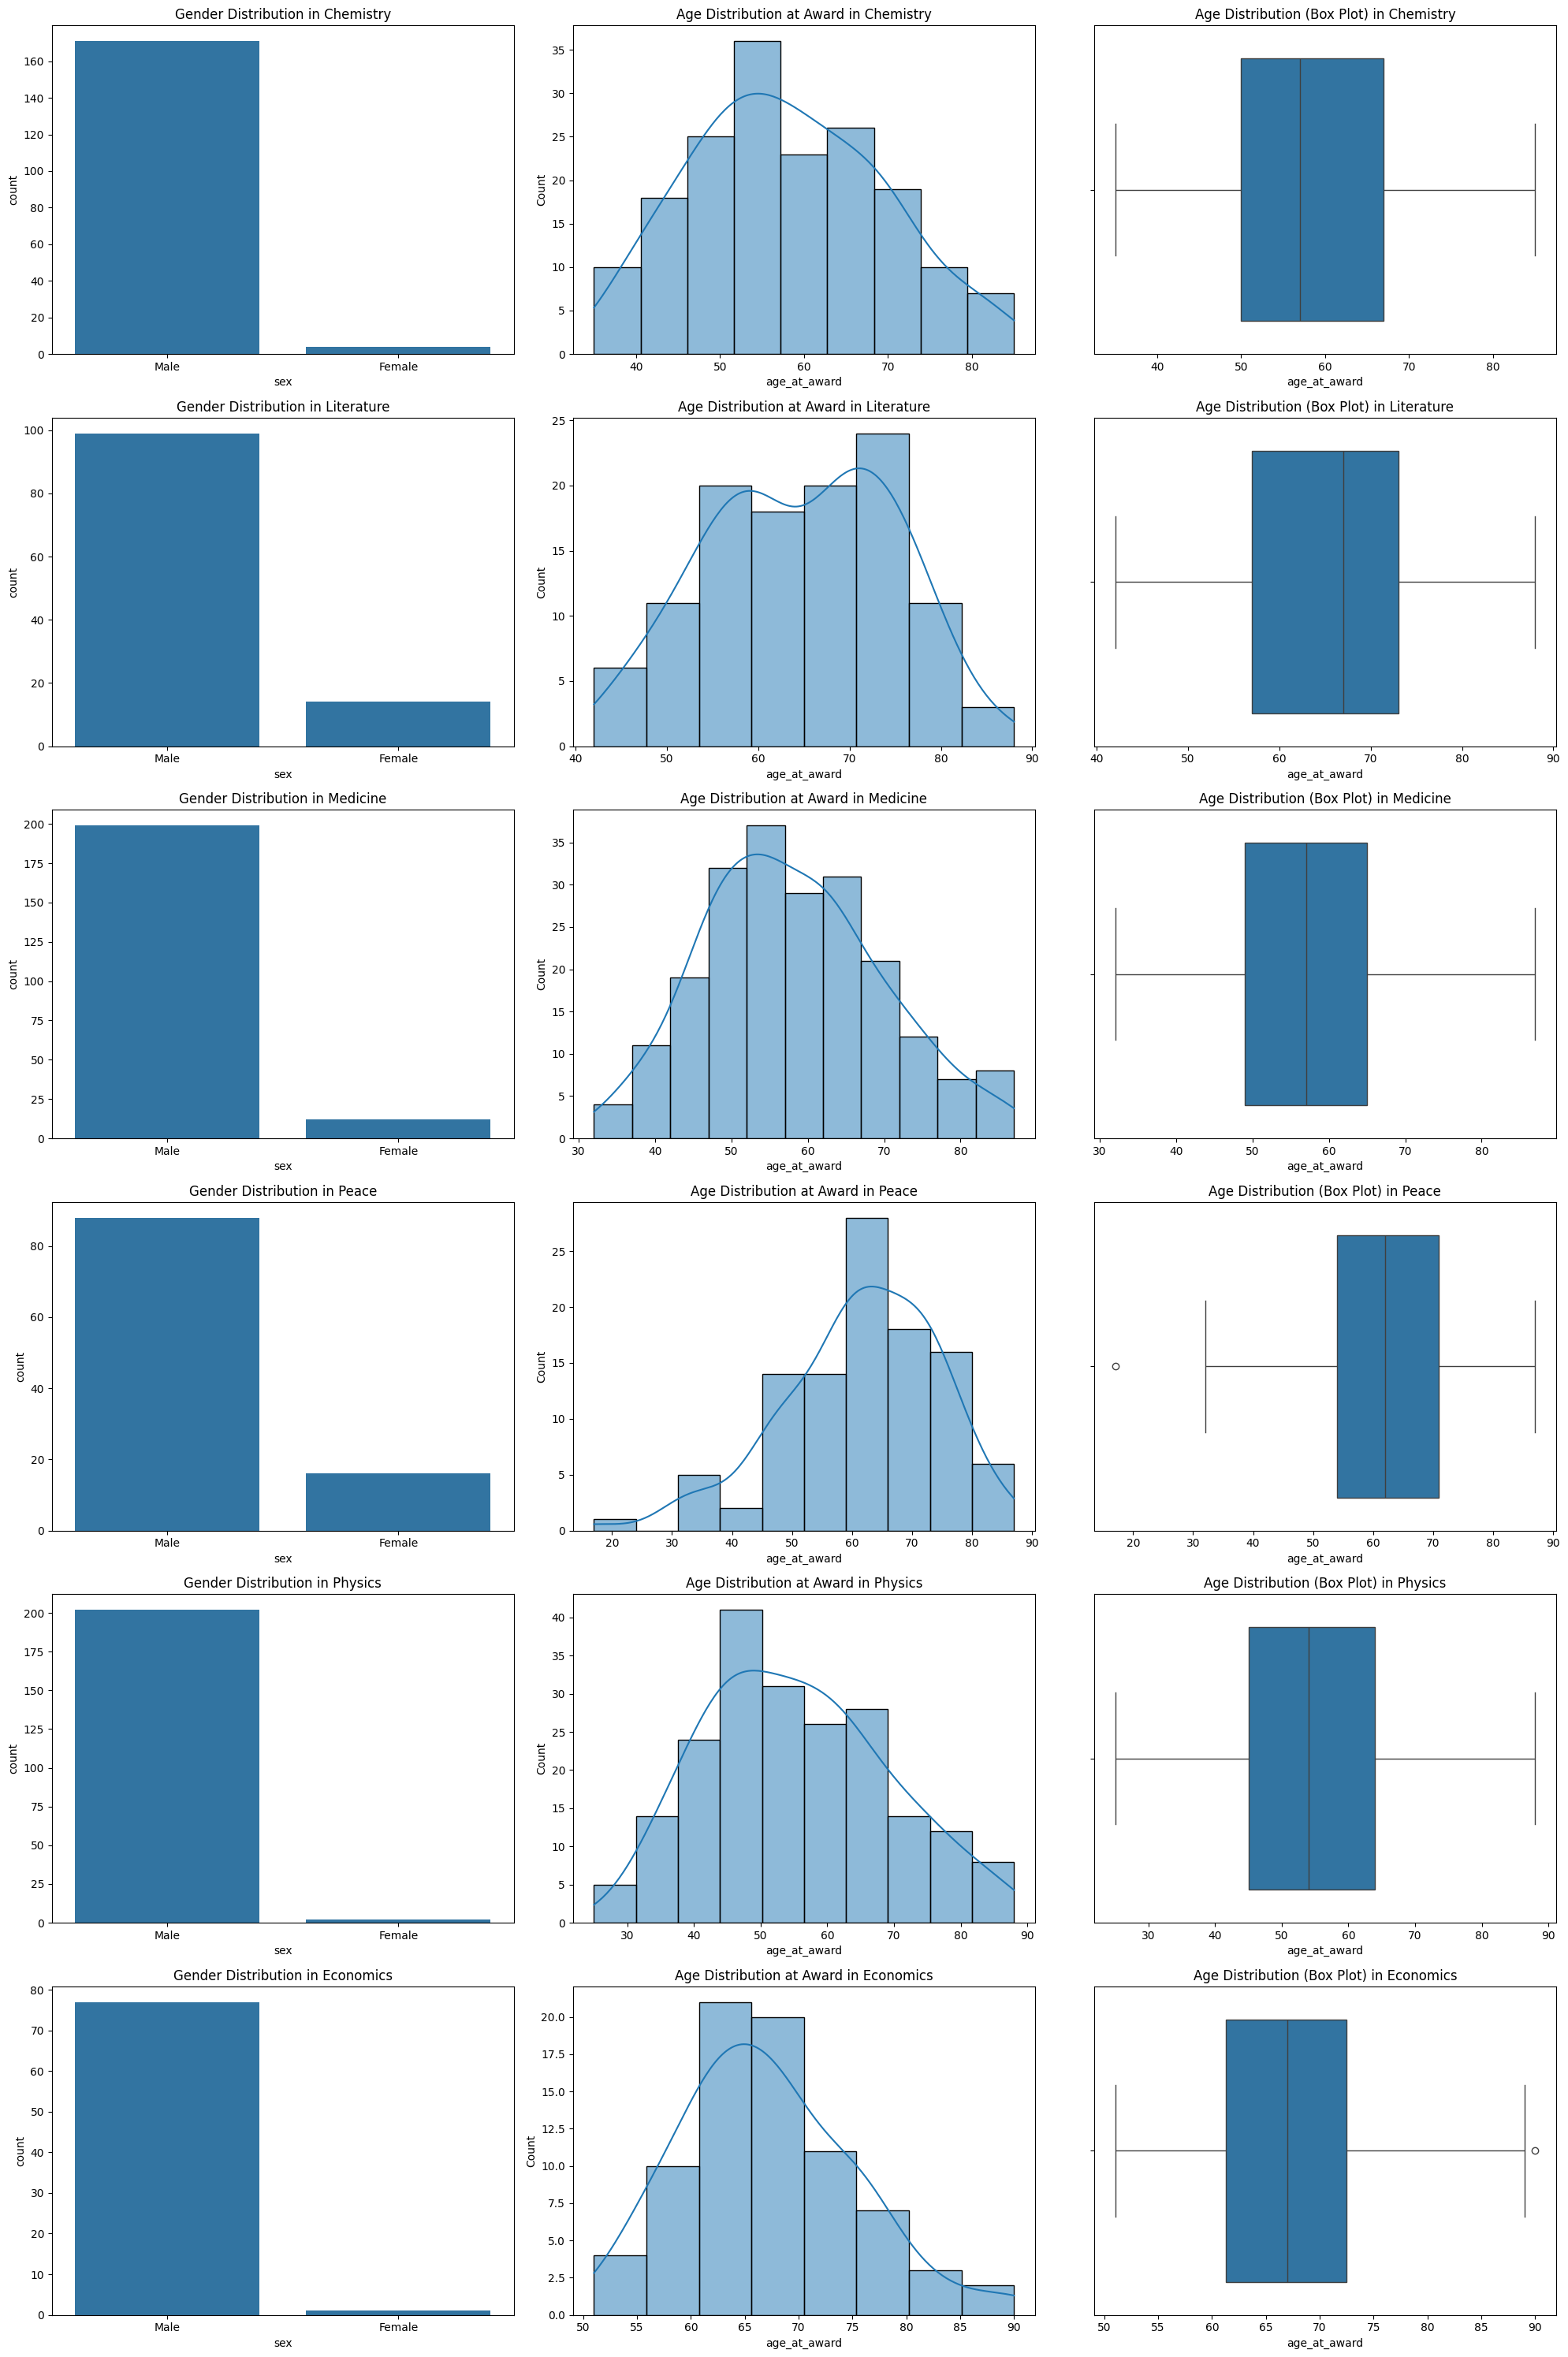

In [281]:
def visualize_age_gender_category(data):
    categories = data['category'].unique()
    fig, axes = plt.subplots(len(categories), 3, figsize=(20, 5 * len(categories)))

    for i, category in enumerate(categories):
        category_data = data[data['category'] == category]

        sns.countplot(x='sex', data=category_data, ax=axes[i, 0])
        axes[i, 0].set_title(f'Gender Distribution in {category}')

        sns.histplot(x='age_at_award', data=category_data, kde=True, ax=axes[i, 1])
        axes[i, 1].set_title(f'Age Distribution at Award in {category}')

        sns.boxplot(x='age_at_award', data=category_data, ax=axes[i, 2])
        axes[i, 2].set_title(f'Age Distribution (Box Plot) in {category}')

    plt.tight_layout()
    plt.show()

visualize_age_gender_category(data)

### QUESTION 6 - 1938-1945 yılı arasında Nobel Ödülü kazananların kategorilerini ve ülkelerini görselleştirip yorumlayınız.

In [290]:
def plot_nobel_prizes_by_country(data, start_year, end_year):
    """
    Plots the normalized distribution of Nobel Prizes by country for each category within a specified time range and saves the plot as a PNG file.
    """
    filtered_data = data[(data['year'] >= start_year) & (data['year'] <= end_year)]
    categories = filtered_data['category'].unique()

    fig, axes = plt.subplots(len(categories), 1, figsize=(12, 6*len(categories)))

    for i, category in enumerate(categories):
        category_data = filtered_data[filtered_data['category'] == category]
        country_counts = category_data['birth_country'].value_counts(normalize=True) * 100

        sns.barplot(x=country_counts.index, y=country_counts.values, ax=axes[i])
        axes[i].set_title(f'Normalized Nobel Prize Winners in {category} ({start_year}-{end_year})')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=35, fontsize=8)
        axes[i].set_xlabel('Country')
        axes[i].set_ylabel('Percentage of Prizes')
        axes[i].tick_params(axis='x', labelsize=8)

    plt.tight_layout()
    plt.show()

C:\Users\alleksenes\AppData\Local\Temp\ipykernel_7704\3355451908.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\alleksenes\AppData\Local\Temp\ipykernel_7704\3355451908.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\alleksenes\AppData\Local\Temp\ipykernel_7704\3355451908.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\alleksenes\AppData\Local\Temp\ipykernel_7704\3355451908.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\alleksenes\AppData\Local\Temp\ipykernel_7704\3355451908.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator



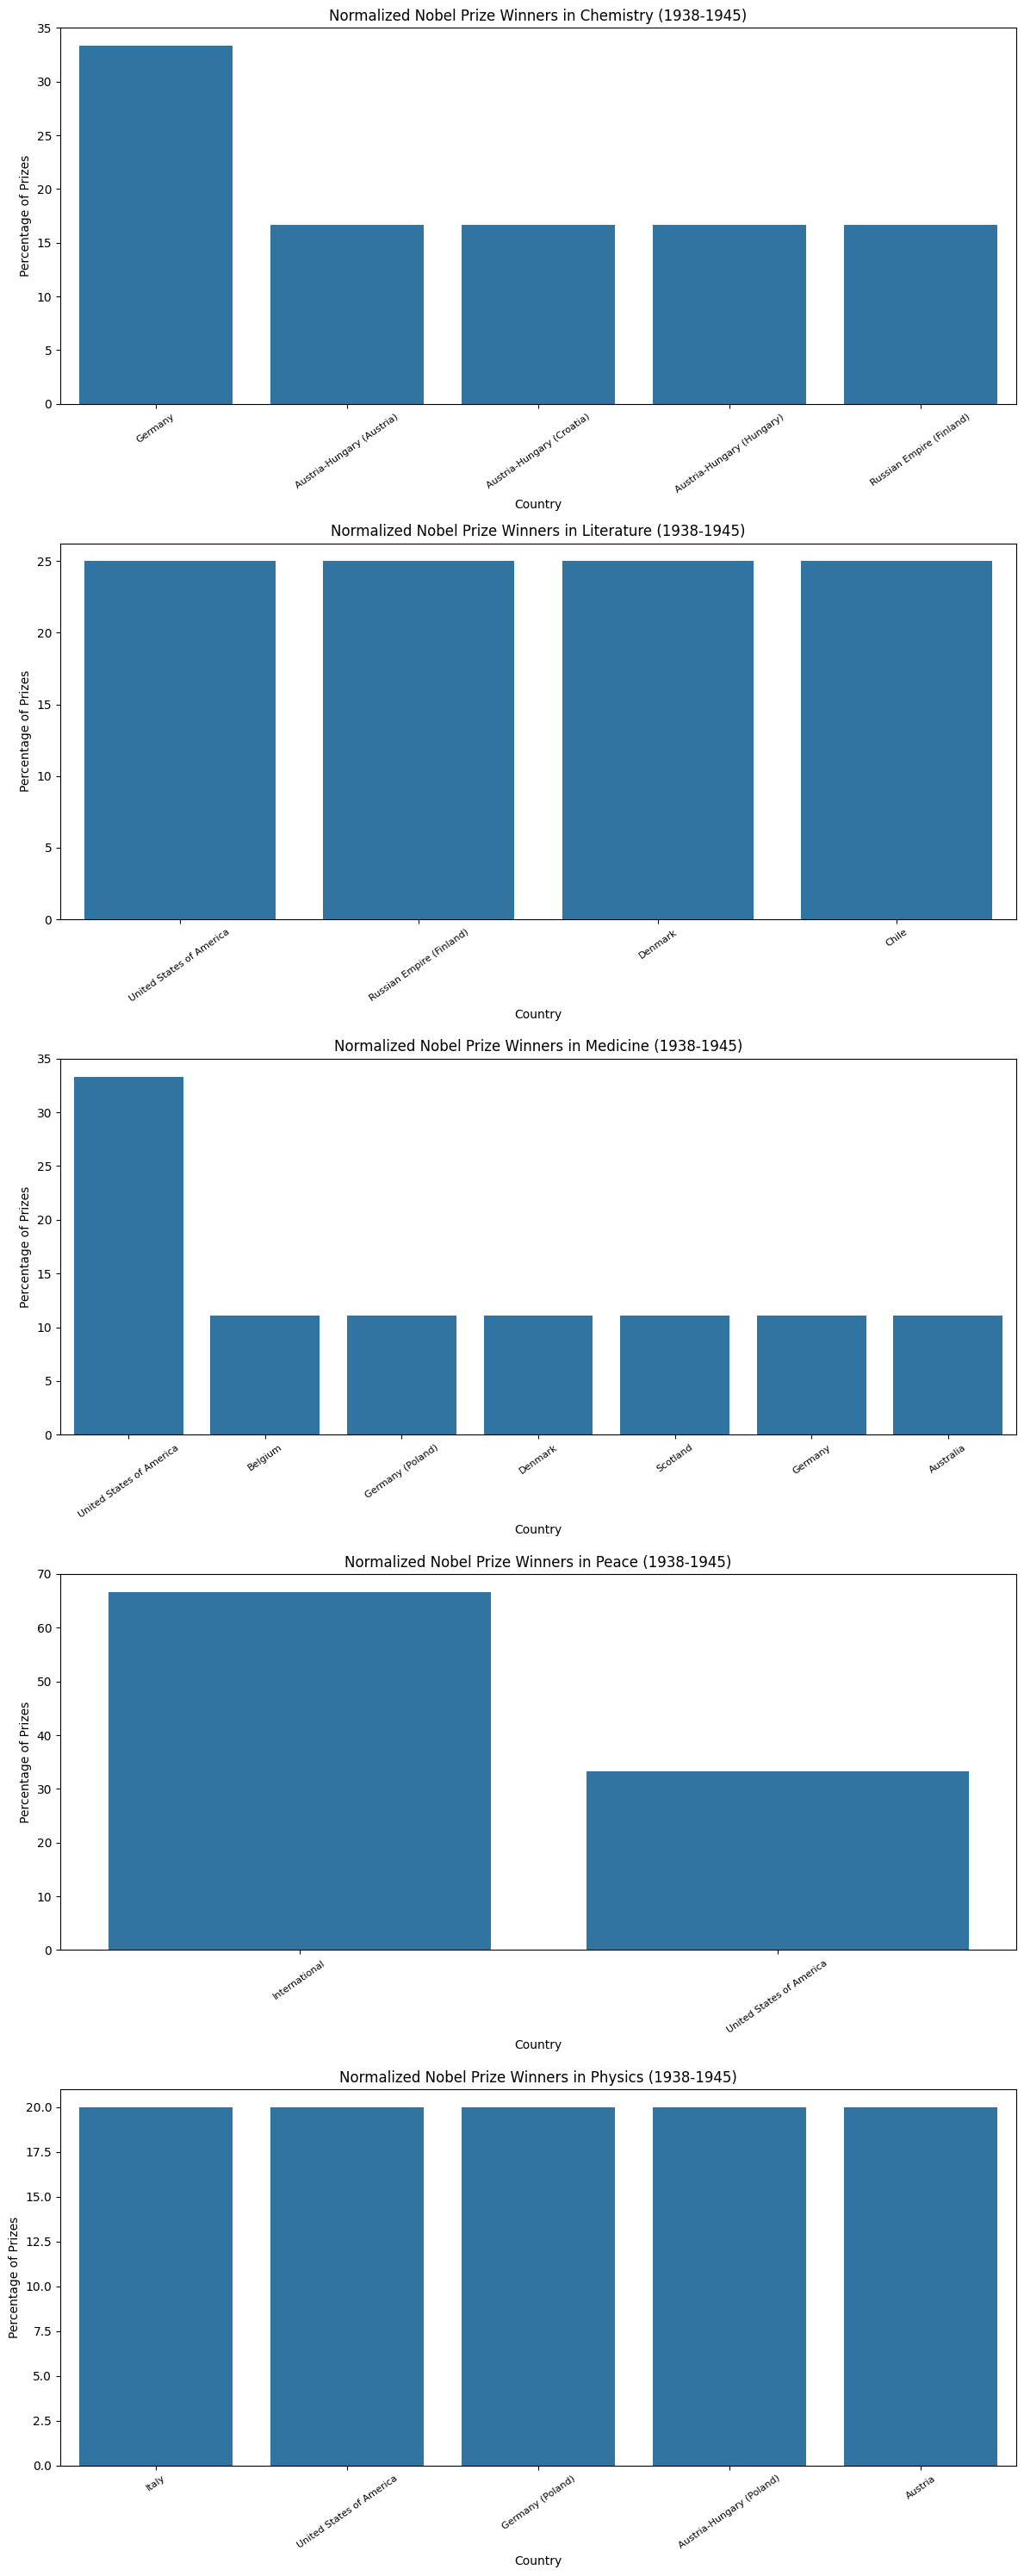

In [291]:
plot_nobel_prizes_by_country(data, 1938, 1945)

### QUESTION 7 - 1947-1991 yılları arasında Nobel Ödülü kazananların kategorilerini ve ülkelerini görselleştirip yorumlayınız.(Her kategori için ayrı bir grafik olması istenmektedir)

In [239]:
def plot_nobel_prizes_1947_1991(data):
    """
    Plots the distribution of Nobel Prizes by country for each category between 1947 and 1991.
    """
    data_1947_1991 = data[(data['year'] >= 1947) & (data['year'] <= 1991)]
    categories = data_1947_1991['category'].unique()

    for category in categories:
        category_df = data_1947_1991[data_1947_1991['category'] == category]
        plt.figure(figsize=(12, 6))
        sns.countplot(x='birth_country', data=category_df)
        plt.title(f'Nobel Prize Winners in {category} (1947-1991)')
        plt.xticks(rotation=66, fontsize=8)
        plt.xlabel('Country')
        plt.tight_layout()
        plt.show()

C:\Users\alleksenes\AppData\Local\Temp\ipykernel_7704\3355451908.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\alleksenes\AppData\Local\Temp\ipykernel_7704\3355451908.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\alleksenes\AppData\Local\Temp\ipykernel_7704\3355451908.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\alleksenes\AppData\Local\Temp\ipykernel_7704\3355451908.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\alleksenes\AppData\Local\Temp\ipykernel_7704\3355451908.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\alleksenes\AppData\Local\Temp\ipykernel_7704\3355451908.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator



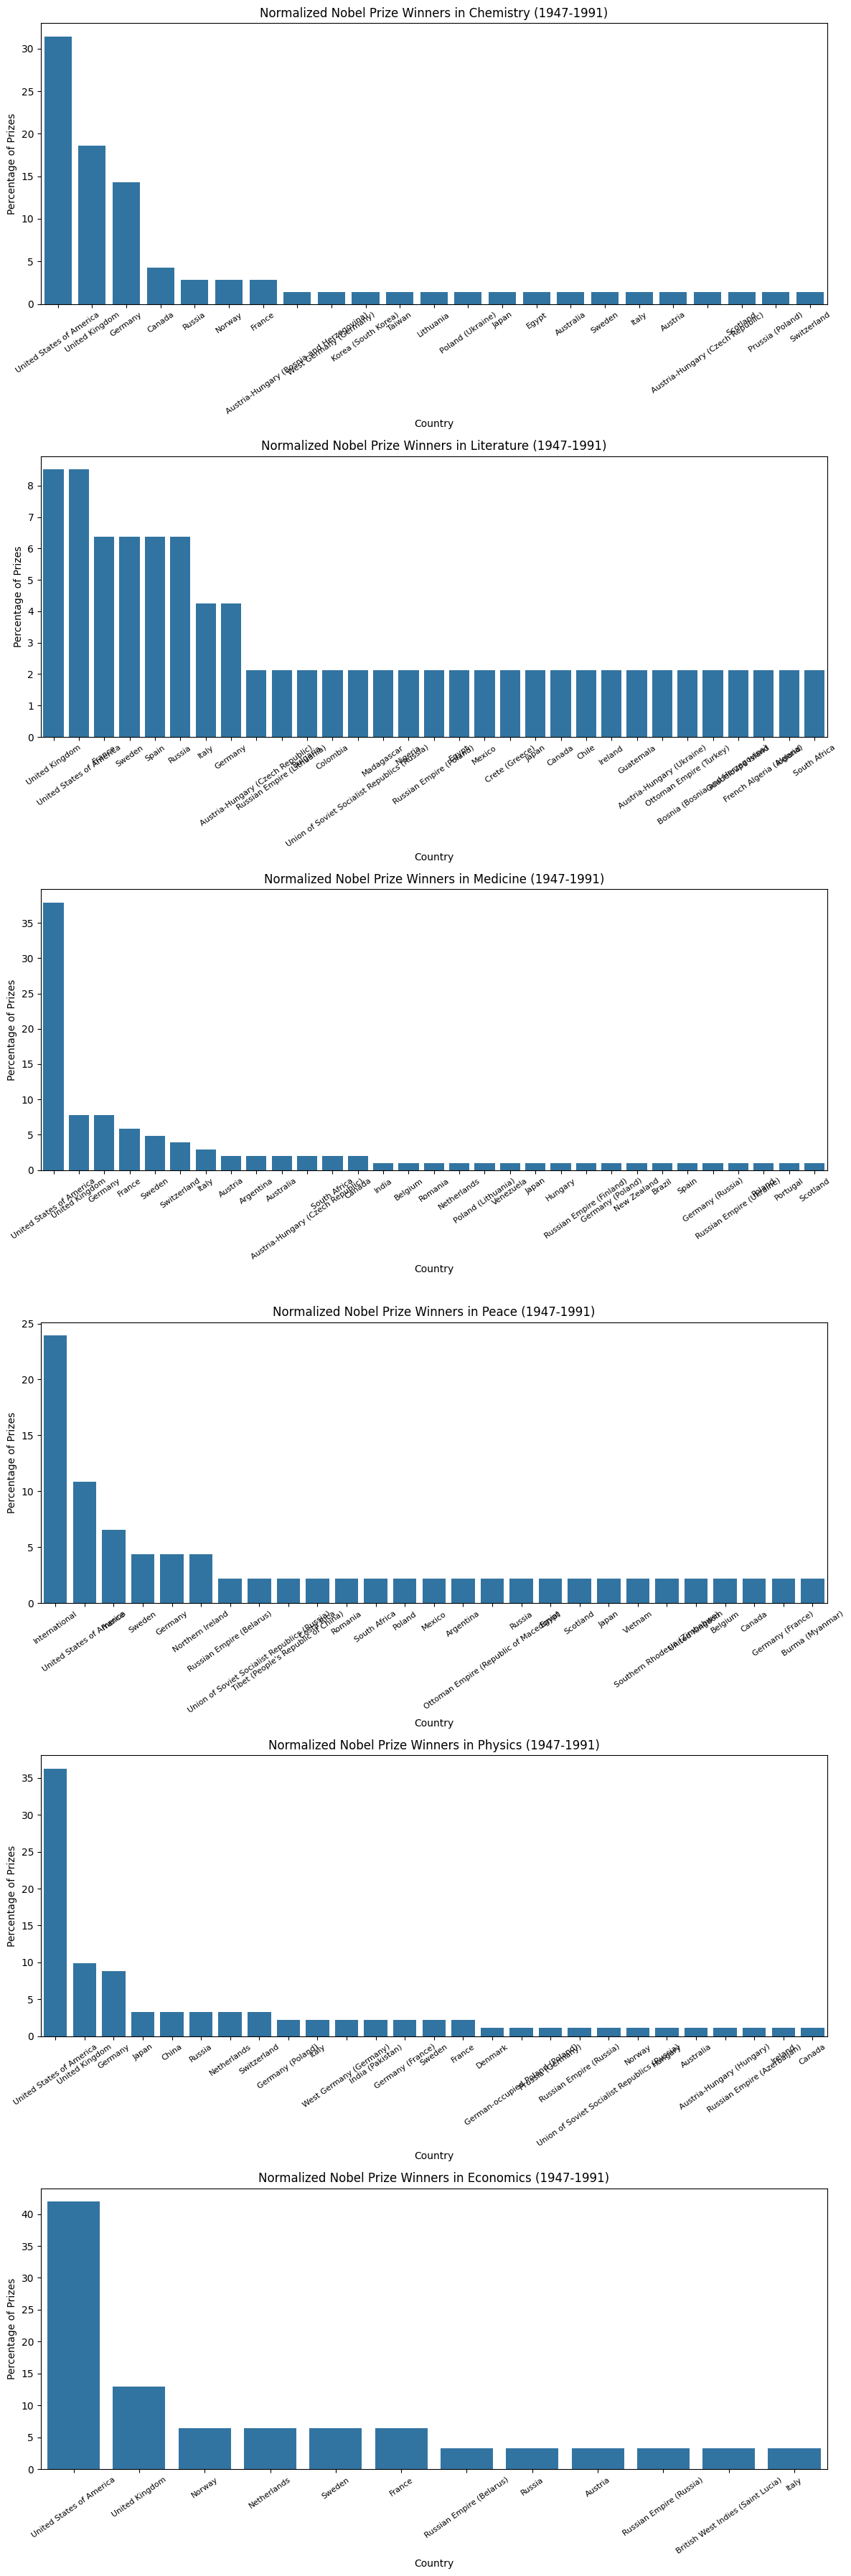

In [292]:
plot_nobel_prizes_by_country(data, 1947, 1991)

### QUESTION 8 - Kimya, Edebiyat, Barış, Fizik ve Tıp kategorilerindeki 2000 sonrasındaki kişilerin ülkelerini, yaşlarını görselleştirin.(Her bir Kategori için ayrı görselleştirme yapılması istenmektedir) Veriyi yorumlayınız.

In [293]:
def visualize_post_2000_nobel_prizes(data):
    """
    Visualizes the country and age distribution of Nobel laureates for each category after 2000 and saves the plot as a PNG file.
    """
    data_after_2000 = data[data['year'] > 2000]
    categories = data_after_2000['category'].unique()
    num_categories = len(categories)

    fig, axes = plt.subplots(num_categories, 2, figsize=(15, 5 * num_categories))

    for i, category in enumerate(categories):
        category_data = data_after_2000[data_after_2000['category'] == category]

        sns.countplot(x='birth_country', data=category_data, ax=axes[i, 0])
        axes[i, 0].set_title(f'Country Distribution in {category} (After 2000)')
        axes[i, 0].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i, 0].set_xlabel('Country')

        sns.histplot(x='age_at_award', data=category_data, kde=True, ax=axes[i, 1])
        axes[i, 1].set_title(f'Age Distribution in {category} (After 2000)')

    plt.tight_layout()
    plt.show()

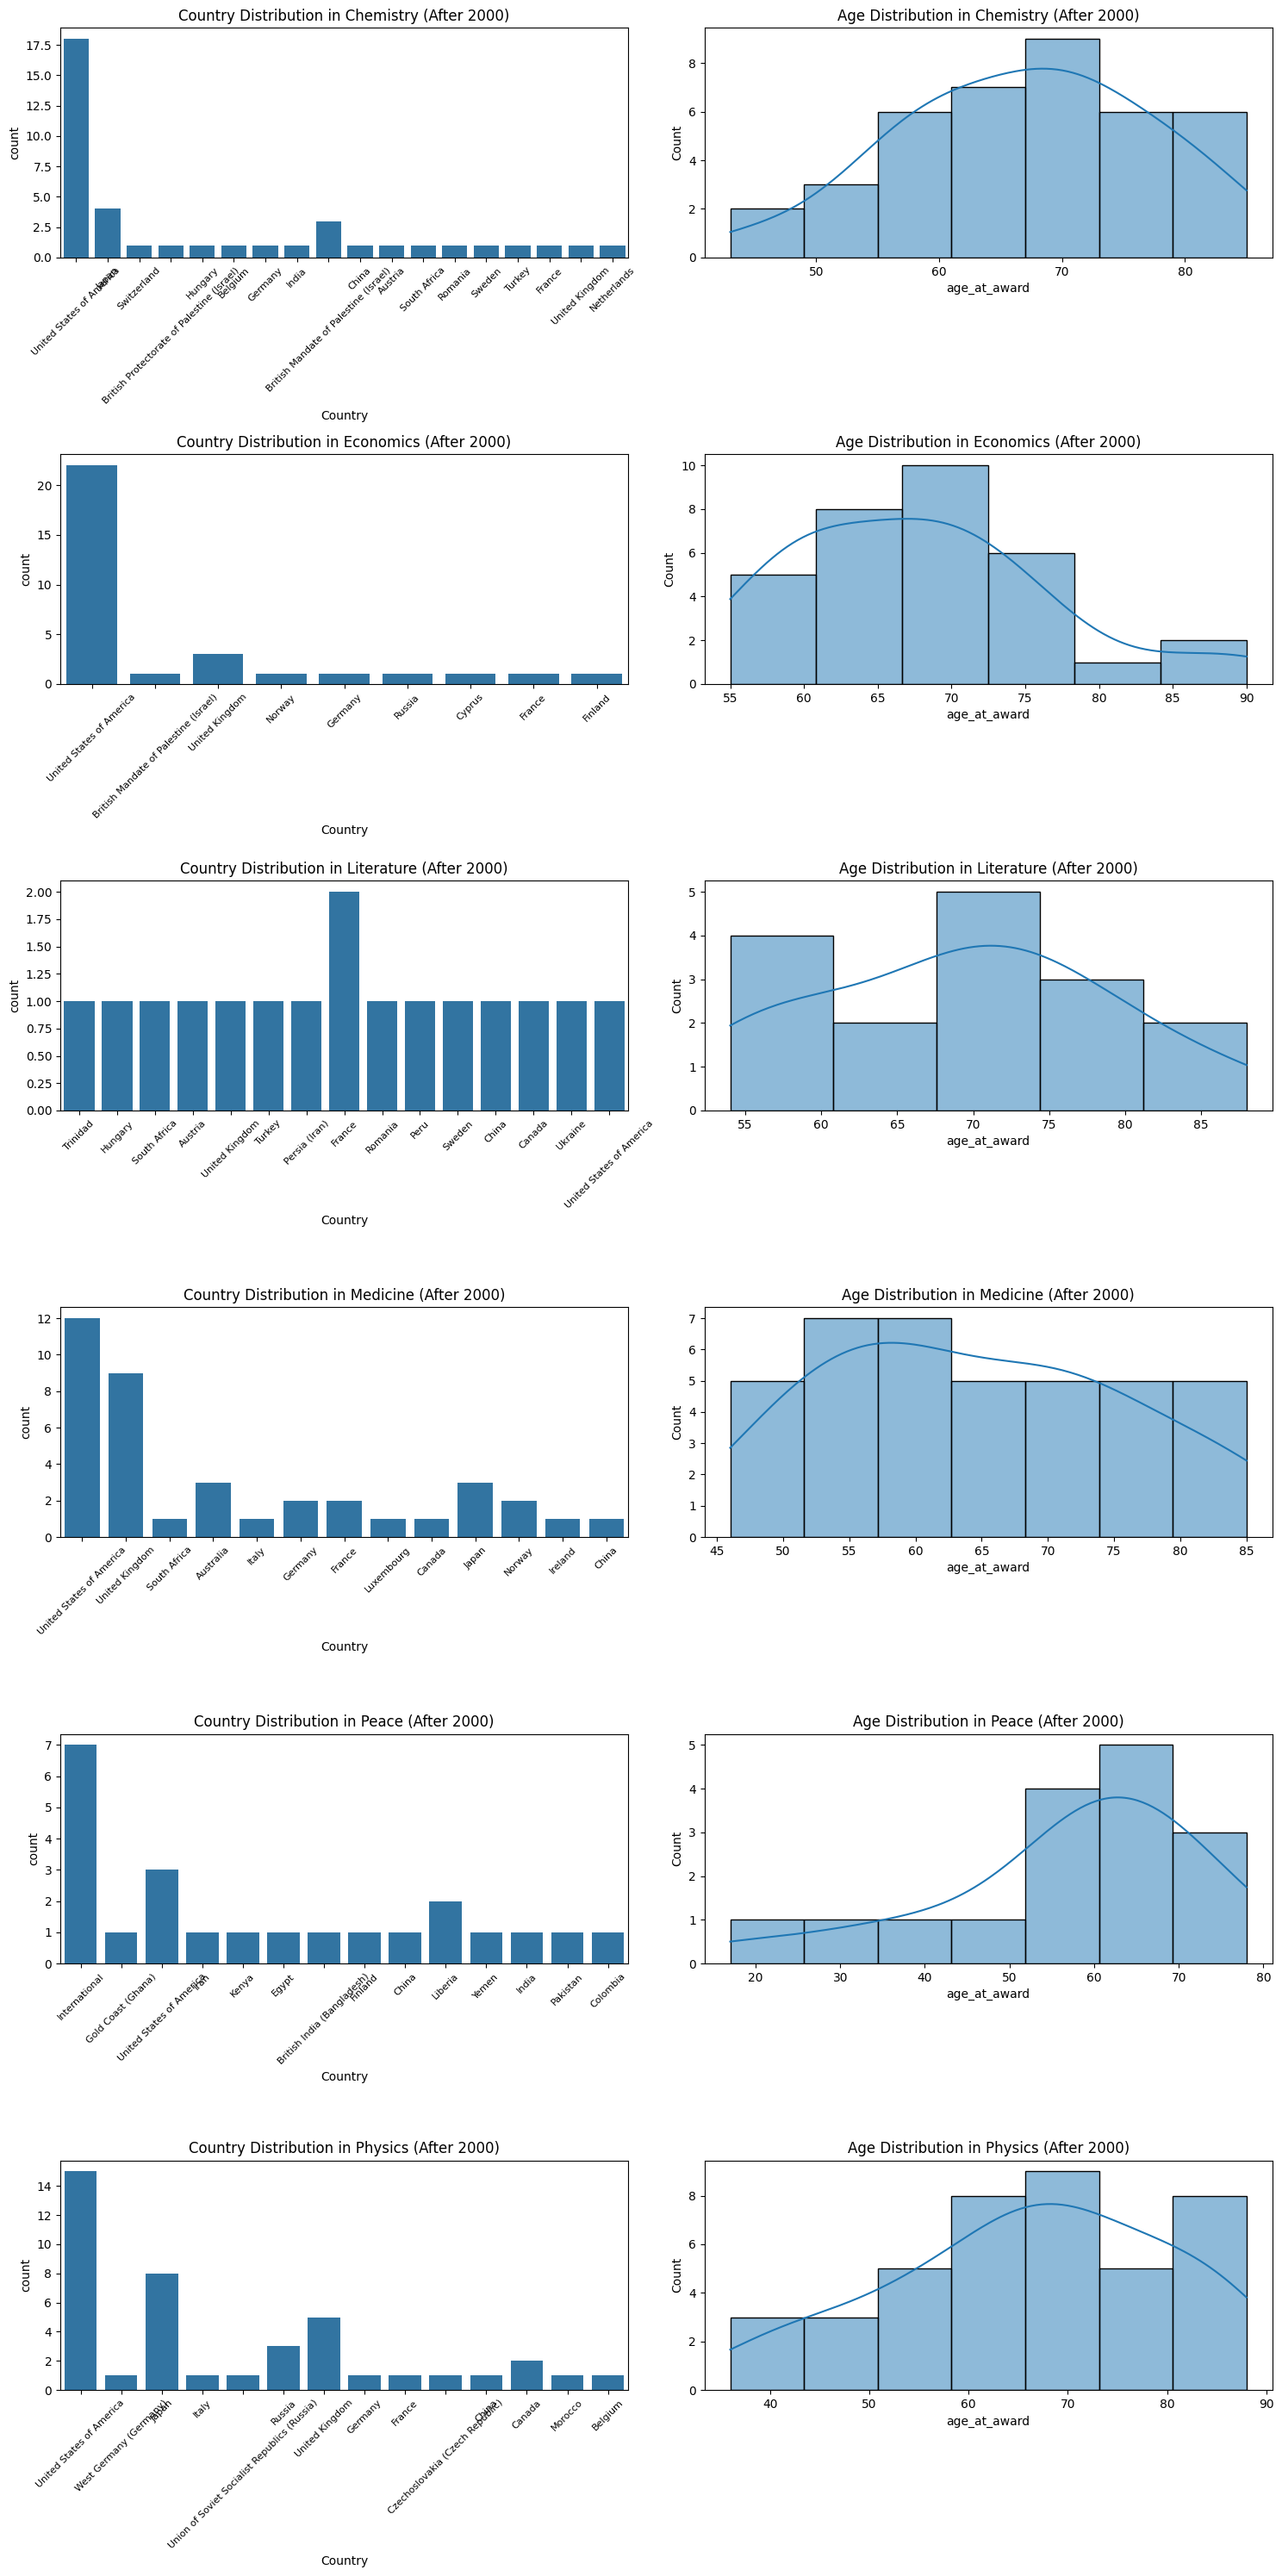

In [294]:
visualize_post_2000_nobel_prizes(data)

### Addendum: Map Visual of Laureates by Birth Country

In [278]:
def visualize_laureates_by_birth_country_map(data):
    """
    Visualizes Nobel laureates by birth country on a world map using geocoding.
    """

    CACHE_FILE = "geocoding_cache.csv"

    try:
        geocode_cache = pd.read_csv(CACHE_FILE, index_col="country").to_dict('index')
    except FileNotFoundError:
        geocode_cache = {}

    geolocator = Nominatim(user_agent="nobel_app", timeout=5)

    @retry(stop=stop_after_attempt(5),
           wait=wait_exponential(multiplier=1, min=4, max=60),
           retry=retry_if_exception_type((GeocoderTimedOut, GeocoderServiceError)))
    def geocode_country(country):
        if country in geocode_cache:
            lat, lon = geocode_cache[country]['latitude'], geocode_cache[country]['longitude']
            return lat, lon
        try:
            location = geolocator.geocode(country)
            if location:
                geocode_cache[country] = {'latitude': location.latitude, 'longitude': location.longitude}
                return location.latitude, location.longitude
            else:
                geocode_cache[country] = {'latitude': None, 'longitude': None}
                return None, None
        except Exception as e:
            print(f"Error geocoding {country}: {e}")
            return None, None
        finally:
            geocode_df = pd.DataFrame.from_dict(geocode_cache, orient='index')
            geocode_df.index.name = 'country'
            geocode_df.to_csv(CACHE_FILE)

    data[['birth_latitude', 'birth_longitude']] = data['birth_country'].apply(
        lambda x: pd.Series(geocode_country(x)))

    fig = px.scatter_geo(data,
                         lat="birth_latitude",
                         lon="birth_longitude",
                         hover_name="full_name",
                         color="category",
                         projection="natural earth",
                         title="Nobel Laureates by Birth Country")
    fig.show()

visualize_laureates_by_birth_country_map(data.copy())